<a href="https://colab.research.google.com/github/jordi1215/quantum-reinforcement-learning/blob/main/QRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

class QRLearner:
    """A class to represent a 'quantum' reinforcement learner
    """

    def __init__(self, num_states,  num_actions, k=1., gamma=.99, alpha=.06, algo="reward"):
        """Initialize the policy.

        Tabular representations are used, so we need to know the number of states/actions up front.
        k is the magic parameter that determines how many Grover iterations to apply
        """

        # estimated state values
        self.V = np.zeros(num_states)
        # state-action coefficients
        # When squared, they represent the stochastic policy
        # Uniform initialization
        self.action_coefs = np.ones((num_states, num_actions)) / num_actions ** .5
        self.k = k
        self.s = np.ones(num_actions) / num_actions ** .5
        self.num_actions = num_actions
        self.gamma = gamma
        self.alpha = alpha
        self.grover_theta = theta = np.arcsin(1./num_actions**.5)
        self.max_its = int(np.pi/(4*theta))
        self.algo = algo
        #print(f"Maximum Grover iterations: {self.max_its}")

    def update(self, state, action, reward, next_state):
        """Perform a TD update and change the action probabilities.
        """
        # do TD update
        td_diff = reward + self.gamma * self.V[next_state] - self.V[state]
        self.V[state] += self.alpha * td_diff
        # Update action probabilities
        omega = np.zeros(self.num_actions)
        omega[action] = 1
        # Determine number of Grover iterations
        if self.algo == "reward":
          grover_iterations = min(int(self.k*(reward + self.V[next_state])), self.max_its)
        elif self.algo == "td_diff":
          grover_iterations = min(int(self.k*td_diff), self.max_its)

        if grover_iterations > 0:
          thetap = np.arccos(np.dot(omega, self.action_coefs[state]))
          # If no rotation needed, return
          if abs(thetap) <= self.grover_theta/2 + 1e-6:
            #print(self.action_coefs[state], action, state)
            return
          #print(f"Updating state {state} after {action}.")
        for i in range(grover_iterations):
            # Apply oracle operator
            self.action_coefs[state] -= 2 * omega * np.dot(omega, self.action_coefs[state])
            # Apply Grover diffusion operator
            self.action_coefs[state] = 2 * self.s * np.dot(self.s, self.action_coefs[state]) - self.action_coefs[state]


    def action(self, state):
        """Take an action based on the stochastic policy.
        """

        probs = self.action_coefs[state]**2
        r = random.random()
        tot = 0
        for i in range(self.num_actions):
            tot += probs[i]
            if tot >= r: return i

        return i

In [ ]:

# global variables
BOARD_ROWS = 20
BOARD_COLS = 20
WIN_STATE = (18, 18)
START = (1, 1)
DETERMINISTIC = True
NUM_STATES = (BOARD_ROWS-2)*(BOARD_COLS-2)

class State:
    DIRECTIONS = [(-1,0), (1, 0), (0, -1), (0, 1)] + [(-1, -1), (-1, 1), (1, -1), (1, 1)]

    def __init__(self, state=START):
        self.state = state
        self.done = False
        # initialize the walls
        wall = set()
        for i in range(BOARD_COLS):
          wall.add((0,i))
          wall.add((BOARD_ROWS - 1,i))
          wall.add((i,0))
          wall.add((i,BOARD_COLS - 1))
        for i in range(4):
          wall.add((2, i+1))
        for i in range(7):
          wall.add((i+1,7))
        for i in range(2):
          wall.add((7,i+5))
        for i in range(8):
          wall.add((10,i+2))
        for i in range(3):
          wall.add((14+i,2))
        for i in range(6):
          wall.add((BOARD_ROWS - 4,i+2))
        for i in range(5):
          wall.add((14,8+i))
        for i in range(7):
          wall.add((12+i,BOARD_COLS-5))
        for i in range(4):
          wall.add((7,i+11))
        for i in range(4):
          wall.add((6,i+11))
        for i in range(4):
          wall.add((5,i+11))
        for i in range(4):
          wall.add((4,i+11))

        self.wall = wall

    def giveReward(self):
        if self.state == WIN_STATE:
            return 100
        else:
            return -1

    def isEndFunc(self):
        if self.state == WIN_STATE:
            return True

    def nxtPosition(self, action):
        """
        action: up, down, left, right
        -------------
        0 | 1 | 2| 3|
        1 |
        2 |
        return next position
        """
        d = self.DIRECTIONS[action]
        nxtState = (self.state[0] + d[0], self.state[1] + d[1])
        # if next state legal
        if (0 < nxtState[0] <= (BOARD_ROWS -1)) and (0 < nxtState[1] <= (BOARD_COLS -1)):
                if nxtState not in self.wall:
                    self.state = nxtState
        return self.state

    def step(self, action):
        self.nxtPosition(action)
        self.done = self.isEndFunc()
        return self.state, self.giveReward(), self.done

    def showBoard(self):
        for i in range(0, BOARD_ROWS):
            # print('-----------------')
            print("")
            out = '| '
            for j in range(0, BOARD_COLS):
                if (i,j) in self.wall:
                    token = 'w'
                elif (i,j) == self.state:
                    token = '*'
                elif (i,j) == WIN_STATE:
                    token = 'G'
                else:
                    token = '0'
                out += token + ' | '
            print(out)
        print("")
        # print('-----------------')

    def reset(self):
        self.state = START
        self.done = False

    @staticmethod
    def state_num(state):
        return (state[0] - 1) * (BOARD_ROWS-2) + state[1] - 1

In [ ]:
MAX_STEPS = 6000

def do_experiment(num_episodes, reps=10, diagonal=False, **kwargs):
    num_actions = 8 if diagonal else 4

    stats = []
    steps = np.zeros((reps, num_episodes))

    for i in range(reps):
      learner = QRLearner(NUM_STATES, num_actions=num_actions, **kwargs)
      for j in range(num_episodes):
          env = State()
          curr = env.state
          trajectory = []
          tot_reward = 0
          for _ in range(MAX_STEPS):
              action = learner.action(State.state_num(curr))
              next, reward, done = env.step(action)
              trajectory.append((State.state_num(curr), action, reward, State.state_num(next)))
              tot_reward += reward
              curr = next
              if done:
                  break

          for t in trajectory[::-1]:
              learner.update(*t)
          steps[i,j] = len(trajectory)

    percentiles = np.percentile(steps, np.array([25, 50, 75]), axis=0)
    err = np.std(steps, axis=0)
    plt.plot(percentiles[1], label="Median")
    plt.ylabel("Steps")
    plt.xlabel("Episodes")
    plt.title(f"QRL alpha={kwargs['alpha']}, k={kwargs['k']}")
    plt.fill_between(np.arange(num_episodes), percentiles[0], percentiles[2],
                     alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

    plt.show()
    return steps, learner



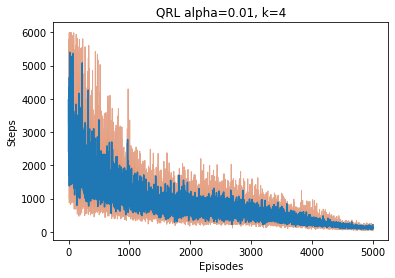

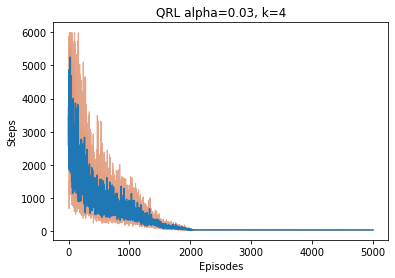

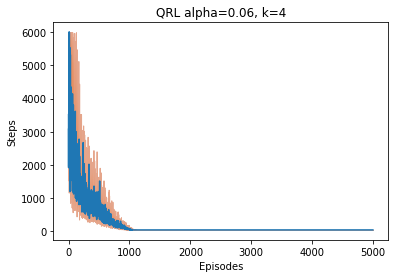

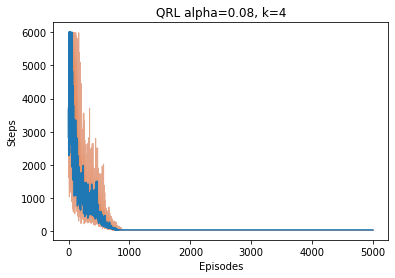

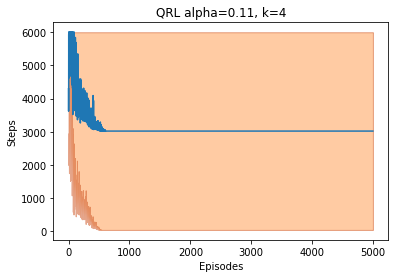

KeyboardInterrupt: ignored

In [ ]:
for alpha in [.01, .03, .06, .08, .11, .15, .2, .25]:
  _ = do_experiment(5000, alpha=alpha, gamma=.99, k=4)

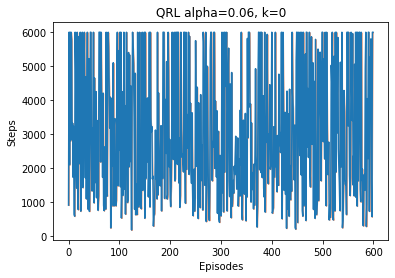

In [ ]:
for k in range()
steps, learner = do_experiment(600, alpha=.06, gamma=.99, k=0, diagonal=True, reps=1, algo="td_diff")

In [ ]:
print(learner.V)

[-99.83213515 -99.83118766 -99.594405   -99.59360979 -98.06310732
 -97.3183029    0.         -17.24117954 -17.20419923 -16.97860044
 -15.63399387 -15.42678048 -14.87259787 -14.76159227 -13.93190261
 -13.85586945 -13.0362858  -12.86540138   0.           0.
   0.           0.         -97.65595551 -96.92871358   0.
 -18.11147821 -17.57616122 -16.17397884 -15.71997558 -15.03577335
 -15.15874228 -14.42426606 -13.96740845 -13.57702391 -12.60436062
 -11.97878228 -94.12397646 -94.2209521  -93.89270429 -94.13807635
 -94.20771579 -93.92437016   0.         -18.0135699  -18.135842
 -17.5603145  -15.87698702 -15.01845333 -15.06402296 -14.86918933
 -13.3804422  -12.91442684 -12.66139027 -11.64660237 -94.15982078
 -93.92935798 -93.7323106  -93.62561083 -93.2475149  -93.22251823
   0.         -16.91190568 -17.80304367 -17.62513322   0.
   0.           0.           0.         -12.86477431 -13.14965865
 -12.51271525 -12.49819249 -94.05492679 -93.65324498 -93.30191844
 -92.8742501  -92.85884549 -93.02928

In [ ]:
coefs = learner.action_coefs
probs = coefs**2
mask = np.where(np.max(probs, axis=1) > .2)
print(mask)
print(np.argmax(probs[mask], axis=1), np.max(probs[mask], axis=1))

(array([231, 232, 233, 249, 250, 251, 267, 268, 269, 285, 286, 287, 303,
       304, 305, 321, 322]),)
[1 1 1 6 7 4 6 4 6 2 0 2 5 0 5 1 4] [0.49063105 0.98429873 0.45947445 0.4696906  0.39928009 0.62659538
 0.62073059 0.28037304 0.45374246 0.78544392 0.76379702 0.48766054
 0.40046693 0.39207335 0.26344873 0.39263377 0.4454941 ]


In [ ]:
steps = do_experiment(10000, .06, .99, k=16, diagonal=True, reps=1)

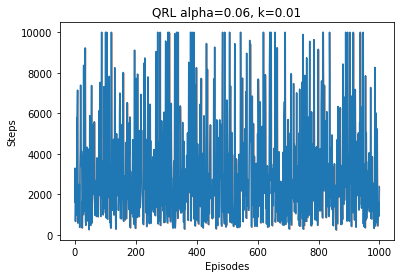

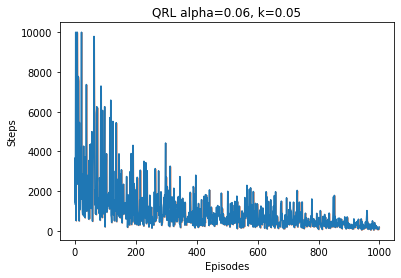

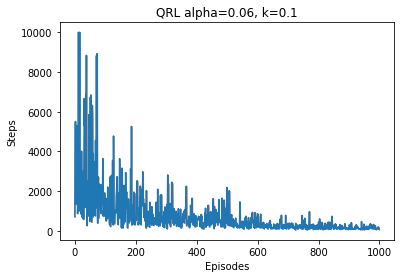

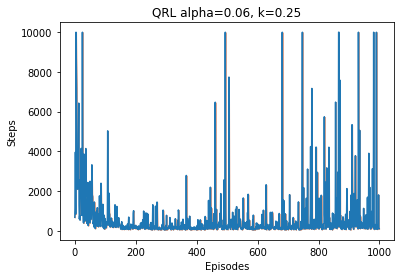

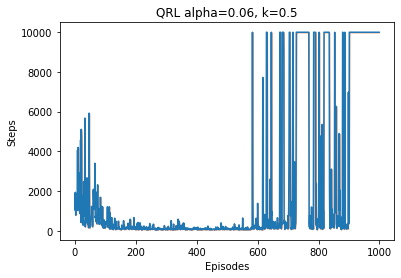

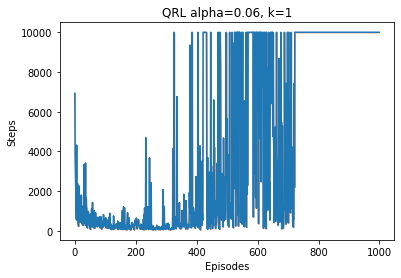

In [ ]:
for k in [.01, .05, .1, .25, .5, 1]:
  #do_experiment(1000, 0.06, 0.99, k)
  do_experiment(1000, alpha=.06, gamma=.99, k=k, diagonal=True, reps=1, algo="td_diff")

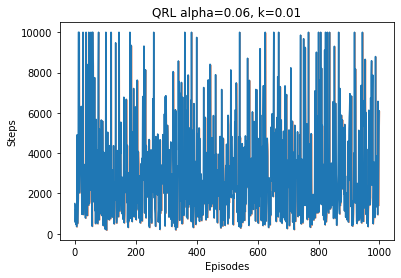

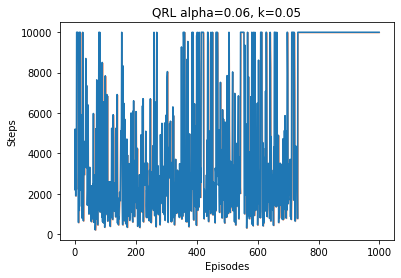

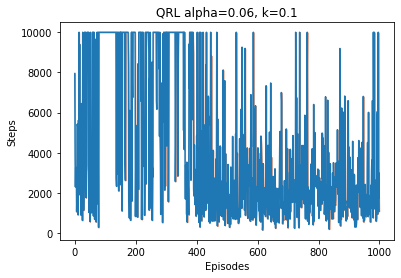

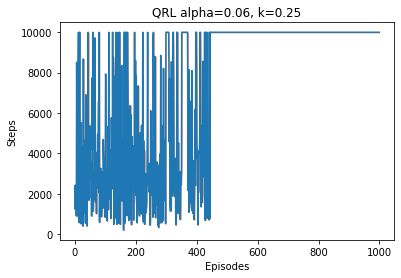

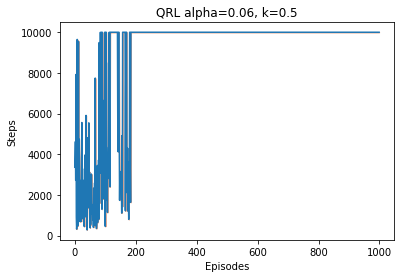

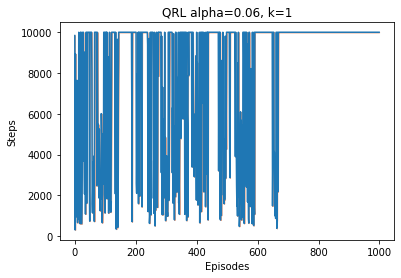

In [ ]:
for k in [.01, .05, .1, .25, .5, 1]:
  #do_experiment(1000, 0.06, 0.99, k)
  do_experiment(1000, alpha=.06, gamma=.99, k=k, diagonal=True, reps=1, algo="reward")

Maximum Grover iterations: 1
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([232, 233, 250, 251, 268, 269, 286, 287, 303, 304, 305, 321, 322]))


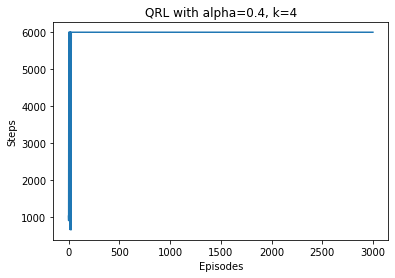

In [ ]:
do_experiment(3000, .4, .99, 4)

In [ ]:
def grover(s, omega, iterations):
    state = s.copy()
    print(state)
    for i in range(iterations):
        # Apply U_omega
        state -= 2 * omega * np.dot(omega, state)
        # apply U_s
        state = 2 * s * np.dot(s, state) - state
        print(i, state)
    return state


In [ ]:
N = 8
s = np.ones(N) / N**.5
omega = np.zeros(N)
omega[0] = 1

print(grover(s, omega, 2)**2)

[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
0 [0.88388348 0.1767767  0.1767767  0.1767767  0.1767767  0.1767767
 0.1767767  0.1767767 ]
1 [ 0.97227182 -0.08838835 -0.08838835 -0.08838835 -0.08838835 -0.08838835
 -0.08838835 -0.08838835]
[0.9453125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125]
